# Dimensionality reduction methods comparison
### Febrary 13, 2019
#### Luis Da Silva

This notebook compares the behaviour of Principal Component Analysis, Factor Analysis and Independent Component Analysis in the 2012 U.S. Army Anthropometric Survey data (ANSUR 2). Specifically, I'm working on a subset of the data referred to measurements of the lower body.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition as skd
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import cross_val_score
from scipy import linalg
from math import sqrt, log
from sklearn.utils.extmath import fast_logdet

# Helper functions

In [2]:
def score(model, X, scoring=None):
    n = X.shape[1]
    scores = []
    
    for i in range(1, n+1):
        model.n_components = i
        scores.append(np.mean(cross_val_score(model, np.array(X), cv=5, scoring=scoring)))
    
    n_max = np.argmax(scores) + 1
    
    return scores, n_max

In [3]:
def calculate_score(estimator, X, y=None):
    components = estimator.components_
    n_features = X.shape[1]
    noise_variance = np.ones(n_features, dtype=X.dtype)

    # Get precision using matrix inversion lemma
    precision = np.dot(components / noise_variance, components.T)
    precision.flat[::len(precision) + 1] += 1.
    precision = np.dot(components.T,
                       np.dot(linalg.inv(precision), components))
    precision /= noise_variance[:, np.newaxis]
    precision /= -noise_variance[np.newaxis, :]
    precision.flat[::len(precision) + 1] += 1. / noise_variance
    
    n_features = X.shape[1]
    log_like = -.5 * (X * (np.dot(X, precision))).sum(axis=1)
    log_like -= .5 * (n_features * log(2. * np.pi)
                      - fast_logdet(precision))
    return np.mean(log_like)

# Read data

In [4]:
female = pd.read_csv("ANSUR_II_FEMALE_Public.csv")
female.shape

(1986, 108)

In [5]:
list(female.columns)

['SubjectId',
 'abdominalextensiondepthsitting',
 'acromialheight',
 'acromionradialelength',
 'anklecircumference',
 'axillaheight',
 'balloffootcircumference',
 'balloffootlength',
 'biacromialbreadth',
 'bicepscircumferenceflexed',
 'bicristalbreadth',
 'bideltoidbreadth',
 'bimalleolarbreadth',
 'bitragionchinarc',
 'bitragionsubmandibulararc',
 'bizygomaticbreadth',
 'buttockcircumference',
 'buttockdepth',
 'buttockheight',
 'buttockkneelength',
 'buttockpopliteallength',
 'calfcircumference',
 'cervicaleheight',
 'chestbreadth',
 'chestcircumference',
 'chestdepth',
 'chestheight',
 'crotchheight',
 'crotchlengthomphalion',
 'crotchlengthposterioromphalion',
 'earbreadth',
 'earlength',
 'earprotrusion',
 'elbowrestheight',
 'eyeheightsitting',
 'footbreadthhorizontal',
 'footlength',
 'forearmcenterofgriplength',
 'forearmcircumferenceflexed',
 'forearmforearmbreadth',
 'forearmhandlength',
 'functionalleglength',
 'handbreadth',
 'handcircumference',
 'handlength',
 'headbread

In [6]:
legs = ['buttockcircumference', 'buttockdepth', 'hipbreadth', 'hipbreadthsitting', 'lowerthighcircumference', 'thighcircumference', 
       'buttockheight', 'buttockkneelength', 'buttockpopliteallength', 'kneeheightsitting',
        'kneeheightmidpatella', 'anklecircumference']

In [7]:
len(legs)

12

# EDA

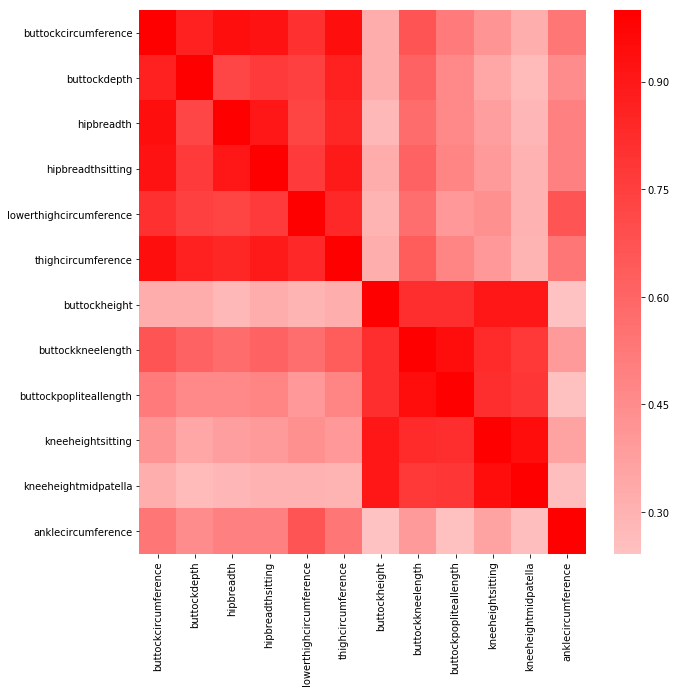

In [8]:
plt.figure(figsize=(10,10))
sns.heatmap(female[legs].corr(), cmap='bwr', center=0)
plt.show()

In [9]:
# As data has different measures, means and variances, it is necessary to scale
def scaler(series):
    return (series - series.mean())/series.std()

In [10]:
fs = female[legs].copy()
for var in legs:
    fs[var] = scaler(fs[var])

In [11]:
male = pd.read_excel("ANSUR_II_MALE_Public.xlsx")
ms = male[legs].copy()
for var in legs:
    ms[var] = scaler(ms[var])

In [12]:
male.shape

(4082, 108)

In [13]:
female['sex'] = 'female'
male['sex'] = 'male'
people = pd.concat([female, male], sort=False)
ps = people[legs].copy()
for var in legs:
    ps[var] = scaler(ps[var])

In [14]:
ps['sex'] = people['sex']

D:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


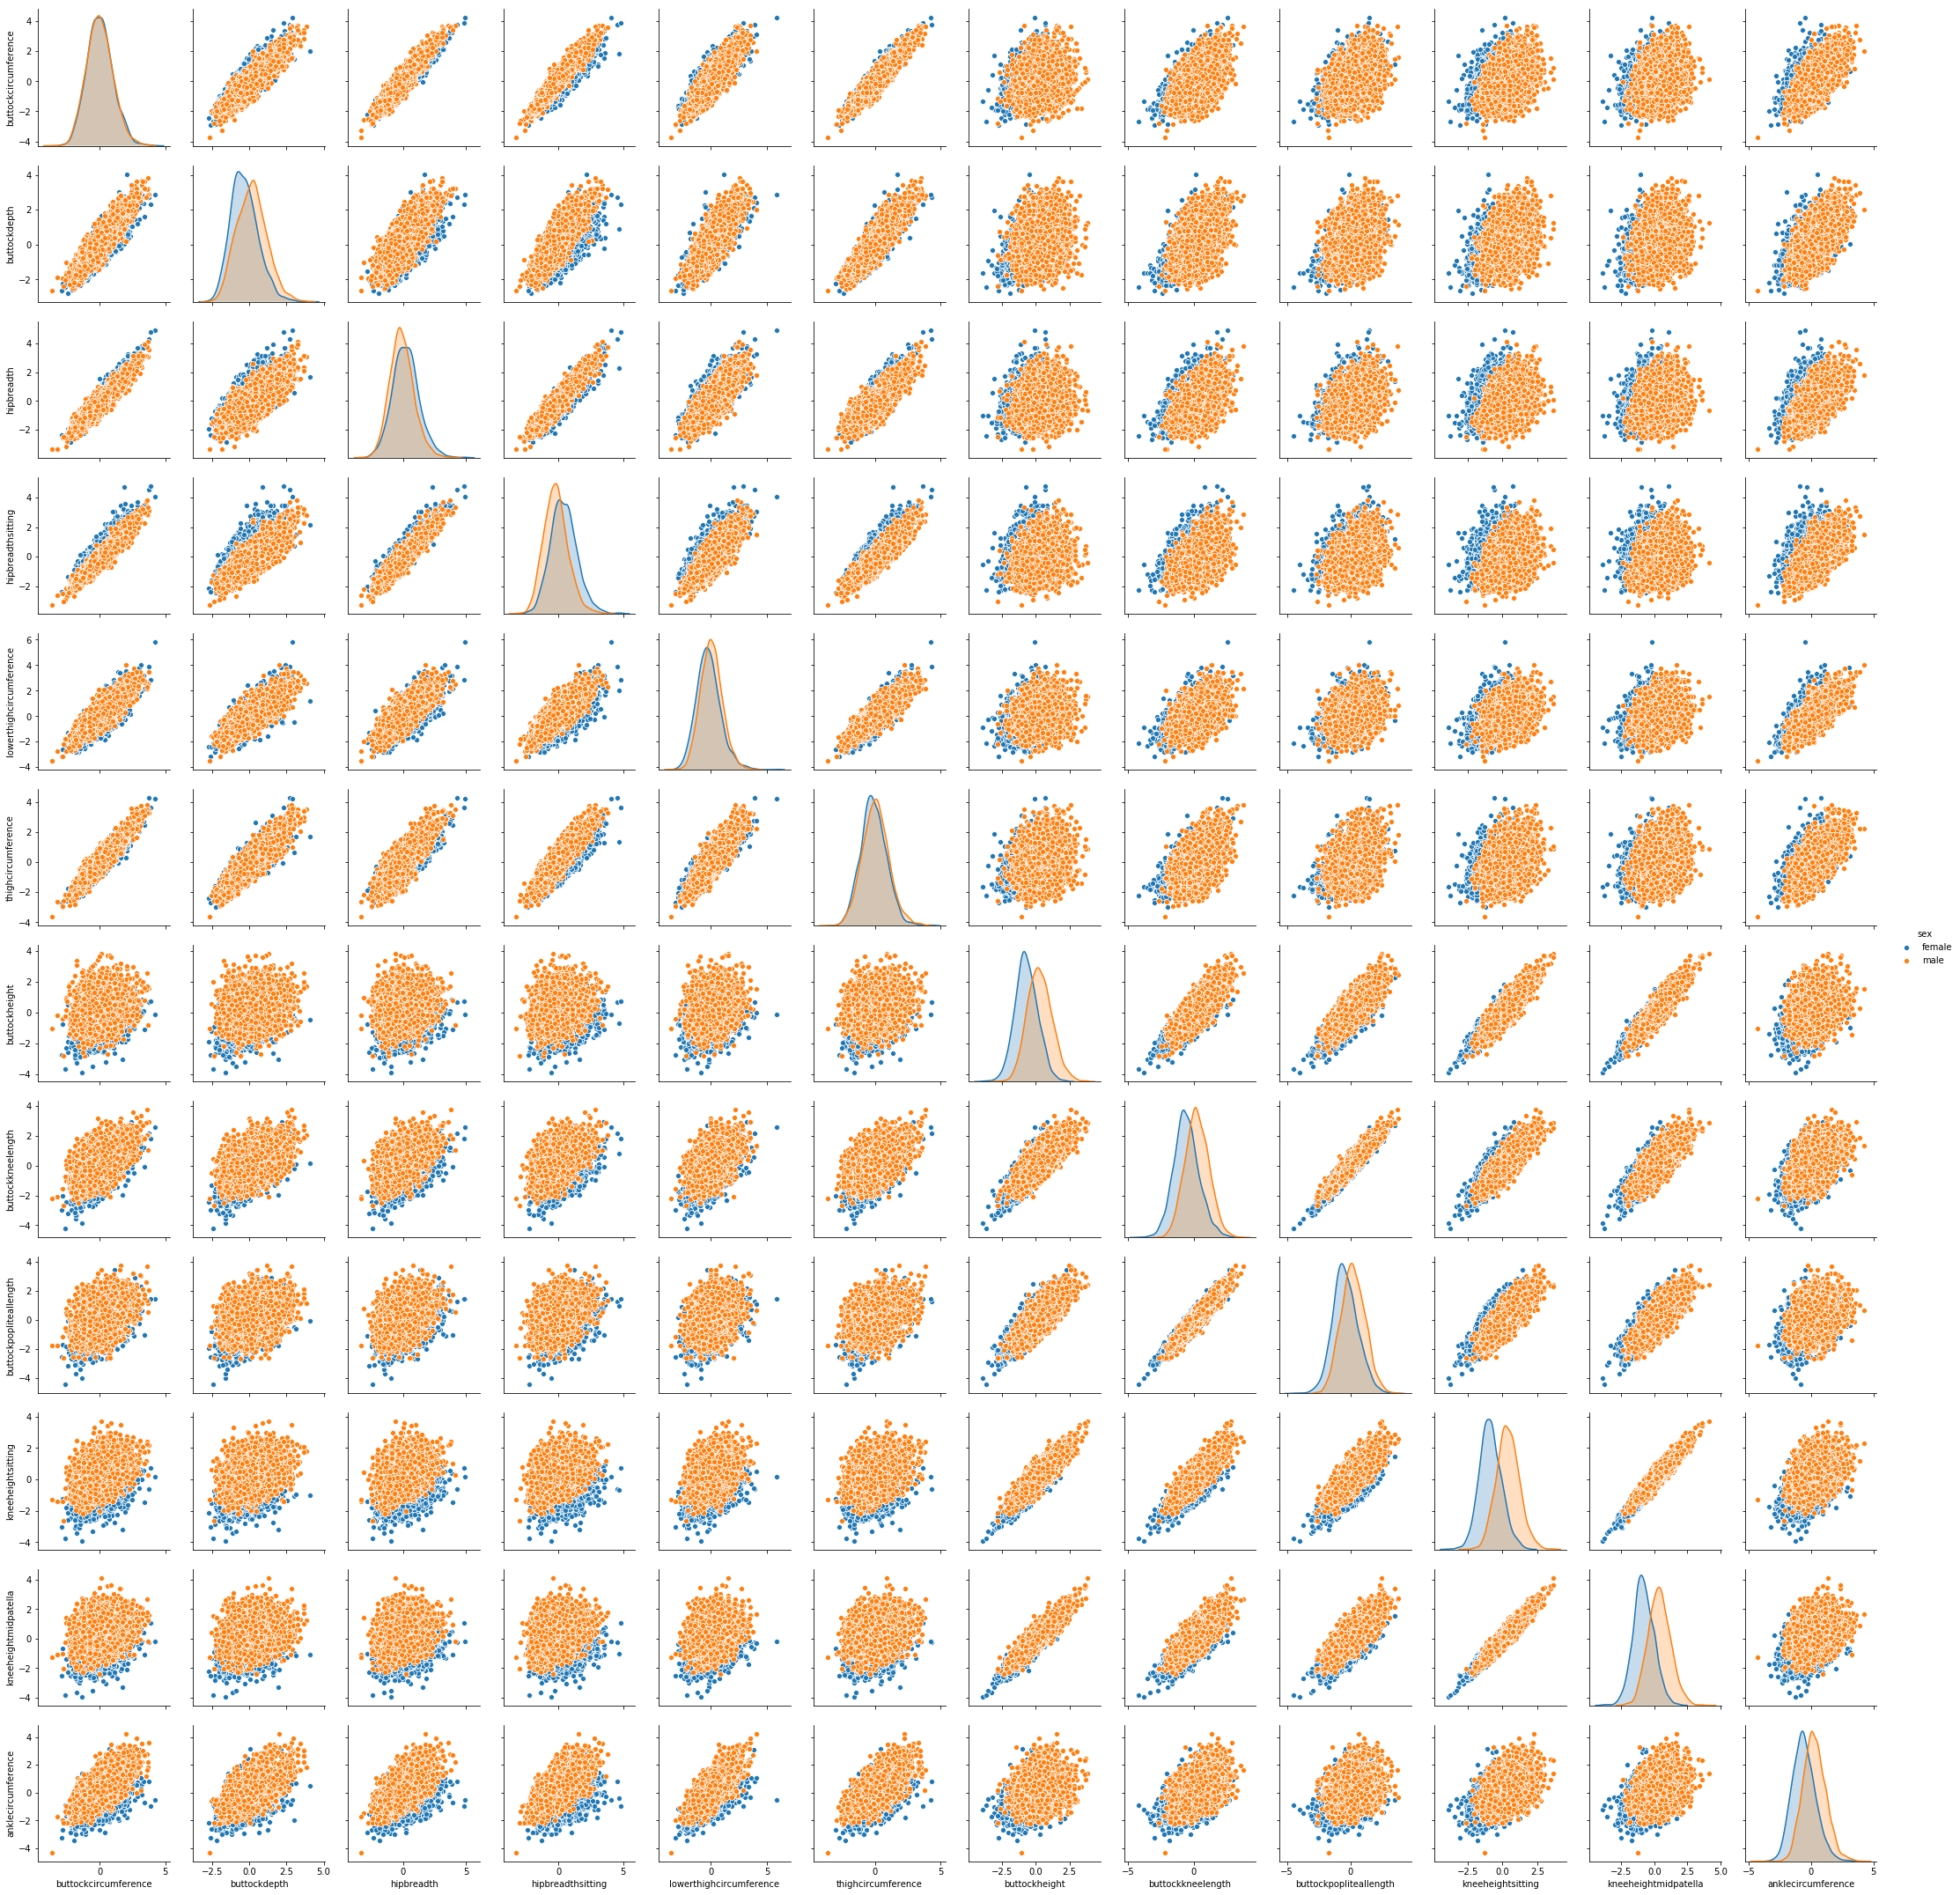

In [15]:
sns.pairplot(ps, hue='sex')
plt.show()

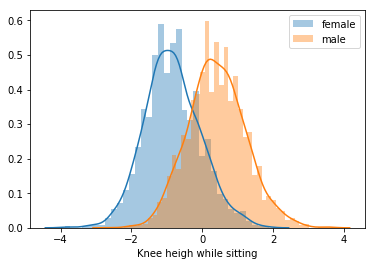

In [16]:
sns.distplot(ps['kneeheightsitting'][ps['sex']=='female'], label='female')
sns.distplot(ps['kneeheightsitting'][ps['sex']=='male'], label='male')
plt.legend()
plt.xlabel("Knee heigh while sitting")
plt.savefig('Graphs/knee_distribution.png')
plt.show()

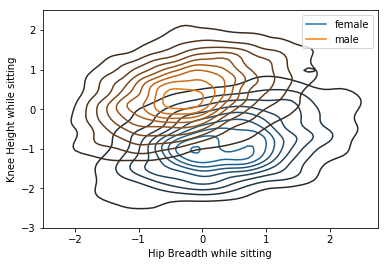

In [17]:
sns.kdeplot(ps['hipbreadthsitting'][ps['sex']=='female'], ps['kneeheightsitting'][ps['sex']=='female'], label='female')
sns.kdeplot(ps['hipbreadthsitting'][ps['sex']=='male'], ps['kneeheightsitting'][ps['sex']=='male'], label='male')
plt.legend()
plt.xlabel('Hip Breadth while sitting')
plt.ylabel('Knee Height while sitting')
plt.xlim((-2.5, 2.75))
plt.ylim((-3, 2.5))
plt.savefig('Graphs/hip_knee.png')
plt.show()

# PCA

In [18]:
pca = skd.PCA(svd_solver='full')
fs_pca = pca.fit_transform(fs)
fs_var_ratio = pca.explained_variance_ratio_

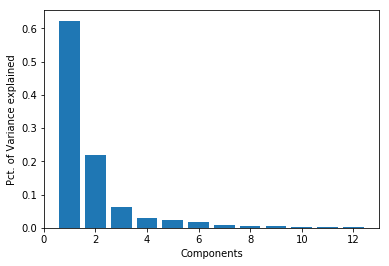

In [19]:
n_features = fs_pca.shape[1]
plt.bar(range(1,n_features+1), fs_var_ratio )
plt.xlabel('Components')
plt.ylabel('Pct. of Variance explained')
plt.savefig('Graphs/pca_component_variance.png')
plt.show()

This is not great, but we may still be safe saying that the data may be represented in only three dimensions

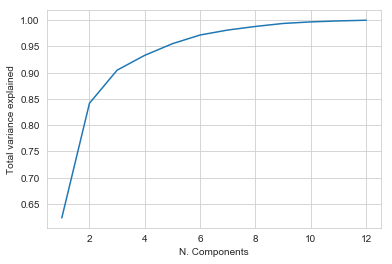

In [21]:
sns.set_style("whitegrid")
sns.lineplot(range(1, n_features+1), fs_var_ratio.cumsum())
plt.xlabel('N. Components')
plt.ylabel('Total variance explained')
plt.savefig('Graphs/pca_cumulative_variance.png')
plt.show()

It doesn't reach the 95% level up until the fifth component

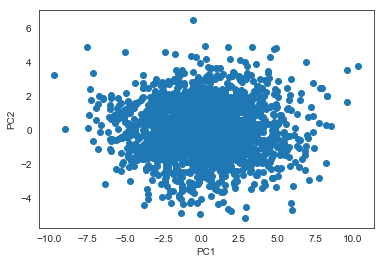

In [22]:
sns.set_style("white")
plt.scatter(fs_pca[:,0], fs_pca[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('Graphs/pca_scatter.png')
plt.show()

As expected, the Principal components are not correlated between each other.

In [23]:
# PCA does average log-likelihood of all samples.
pca_scores, pca_components = score(pca, fs)

In [24]:
fs_pca

array([[-8.77271674e-01,  1.93022868e-01, -5.01660683e-01, ...,
         1.07386487e-01,  1.01900353e-01, -1.01141356e-01],
       [-2.60466870e+00, -3.95368294e+00,  5.72940116e-01, ...,
         1.79393064e-01,  3.21651097e-02, -1.81522650e-02],
       [-1.80470761e-01, -9.55276949e-01,  1.67647398e+00, ...,
         5.28369356e-02,  2.44134101e-01,  6.55380027e-02],
       ...,
       [ 1.84107585e+00, -2.98817544e-01, -8.98720383e-01, ...,
        -5.75193955e-02,  8.84935004e-02,  1.80682700e-01],
       [-6.46931339e-01,  1.22843425e+00, -1.23108012e+00, ...,
         5.27086297e-02,  1.13834033e-01, -7.39907516e-02],
       [-1.62766944e+00, -5.99132240e-01, -5.48675934e-02, ...,
        -2.92425793e-02,  1.61016194e-01,  3.03942888e-03]])

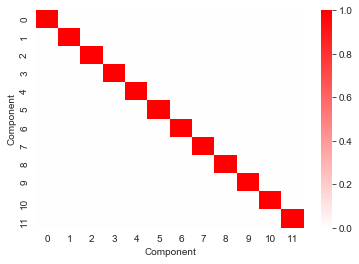

In [25]:
sns.heatmap(pd.DataFrame(fs_pca).corr(), cmap='bwr', center=0)
plt.xlabel('Component')
plt.ylabel('Component')
plt.savefig('Graphs/pca_correlation_map.png')
plt.show()

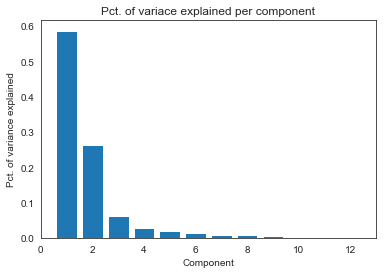

In [26]:
ps_pca = pca.fit_transform(ps.iloc[:,:-1])
ps_var_ratio = pca.explained_variance_ratio_
plt.bar(range(1,n_features+1), ps_var_ratio )
plt.xlabel('Component')
plt.ylabel('Pct. of variance explained')
plt.title('Pct. of variace explained per component')
plt.savefig('Graphs/all_data_pca_variace.png')
plt.show()

D:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


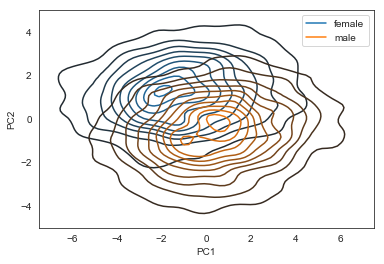

In [27]:
sns.set_style("white")
males = ps['sex'] == 'male'
sns.kdeplot(ps_pca[:,0][~males], ps_pca[:,1][~males], label='female')
sns.kdeplot(ps_pca[:,0][males], ps_pca[:,1][males], label='male')
plt.xlim((-7.5, 7.5))
plt.ylim((-5,5))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.savefig('Graphs/all_pca_kde.png')
plt.show()

The separability of genders with the new components hasn't improved notably

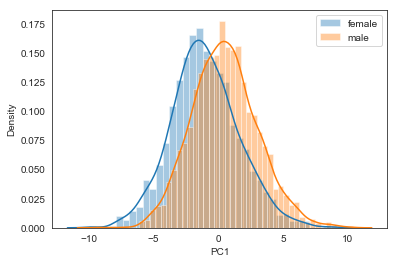

In [28]:
sns.distplot(ps_pca[:,0][ps['sex']=='female'], label='female')
sns.distplot(ps_pca[:,0][ps['sex']=='male'], label='male')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('Density')
plt.savefig('Graphs/pc1_dist.png')
plt.show()

# Independent Component Analysis (ICA)

In [29]:
ica = skd.FastICA(max_iter = 1000, tol=0.01)
fs_ica = ica.fit_transform(fs)

In [30]:
ica_scores, ica_components = score(ica, fs, calculate_score)

D:\Anaconda\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  

D:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


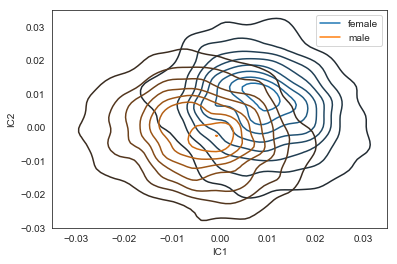

In [31]:
ica = skd.FastICA(n_components = 2, max_iter = 1000, tol=0.001)
ps_ica = ica.fit_transform(ps.iloc[:,:-1])
sns.kdeplot(ps_ica[:,0][~males], ps_ica[:,1][~males], label='female')
sns.kdeplot(ps_ica[:,0][males], ps_ica[:,1][males], label='male')
plt.xlim((-.035, .035))
plt.ylim((-.03,.035))
plt.xlabel('IC1')
plt.ylabel('IC2')
plt.legend()
plt.savefig('Graphs/all_ica_kde.png')
plt.show()

# Factor Analysis

In [32]:
factor = skd.FactorAnalysis()
fs_factor = pd.DataFrame(factor.fit_transform(fs))

In [33]:
fs_factor.shape

(1986, 12)

In [34]:
factor_scores, factor_components = score(factor, fs)

In [35]:
factor_comp = pd.DataFrame(factor.fit(fs).components_.T)

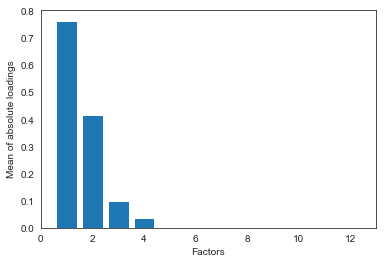

In [36]:
plt.bar(range(1, n_features+1), np.absolute(factor_comp).mean())
plt.xlabel('Factors')
plt.ylabel('Mean of absolute loadings')
plt.savefig('Graphs/factors_bar.png')
plt.show()

D:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


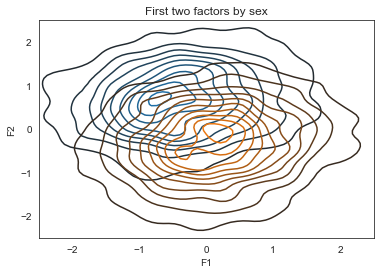

In [37]:
ps_factor = factor.fit_transform(ps.iloc[:,:-1])
sns.kdeplot(ps_factor[:,0][~males], ps_factor[:,1][~males])
sns.kdeplot(ps_factor[:,0][males], ps_factor[:,1][males])
plt.xlim((-2.5,2.5))
plt.ylim((-2.5,2.5))
plt.xlabel('F1')
plt.ylabel('F2')
plt.title('First two factors by sex')
plt.savefig('Graphs/all_factor_scatter.png')
plt.show()

# Plot

In [38]:
pca = skd.PCA(svd_solver='full', n_components='mle')
pca.fit(fs)
n_components_pca_mle = pca.n_components_

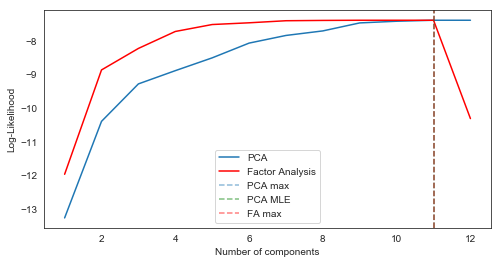

In [39]:
plt.figure(figsize=(8, 4))

plt.plot(range(1, n_features+1), pca_scores, label='PCA')
plt.plot(range(1, n_features+1), factor_scores, label='Factor Analysis', color='r')
plt.axvline(pca_components, label='PCA max', linestyle='--', alpha=.5)
plt.axvline(n_components_pca_mle, label='PCA MLE', linestyle='--', color='g', alpha=.5)
plt.axvline(factor_components, label='FA max', linestyle='--', color='r', alpha=.5)
plt.xlabel("Number of components")
plt.ylabel("Log-Likelihood")
plt.legend()

plt.savefig('Graphs/cv_scores_comparison.png')
plt.show()

Factor Analysis performs better than PCA in this dataset

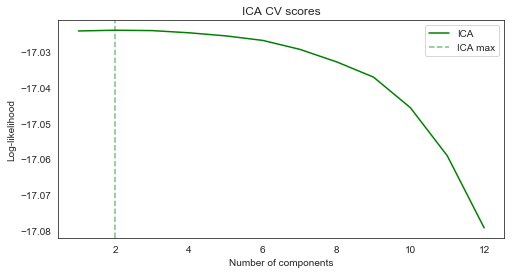

In [40]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, n_features+1), ica_scores, label='ICA', color='g')
plt.axvline(ica_components, label='ICA max', linestyle='--', color='g', alpha=.5)
plt.title("ICA CV scores")
plt.xlabel("Number of components")
plt.ylabel('Log-likelihood')
plt.savefig('Graphs/ica_score_comparison.png')
plt.legend()
plt.show()

ICA's log likelihood is much lower than PCAs and FAs.